<style>
.jp-Notebook {
    padding: var(--jp-notebook-padding);
    margin-left: 160px;
    outline: none;
    overflow: auto;
    background: var(--jp-layout-color0);
}
</style>

# Introduction  

The purpose of this project is to improve my technical skills and problem solving ability by working through something similar to a real NBA data science project. 

**Note:**    

**Throughout this document, any `season` column represents the year each season started. For example, the 2015-16 season will be in the dataset as 2015. For most of the rest of the project, we will refer to a season by just this number (e.g. 2015) instead of the full text (e.g. 2015-16).** 

# Setup and Data    

In [2]:
import pandas as pd
awards = pd.read_csv("awards_data.csv")
player_data = pd.read_csv("player_stats.csv")
team_data = pd.read_csv("team_stats.csv")
rebounding_data = pd.read_csv("team_rebounding_data_22.csv")

## Part 1 -- Awards  

In this section, you're going to work with data relating to player awards and statistics. You'll start with some data manipulation questions and work towards building a model to predict broad levels of career success.  


### Question 1  

**QUESTION:** What is the average number of points per game for players in the 2007-2021 seasons who won All NBA First, Second, and Third teams (**not** the All Defensive Teams), as well as for players who were in the All-Star Game (**not** the rookie all-star game)?


 

In [3]:
def calculate_ppg(player_award):
    # We search the dataset for the number "1" if a player is in the All NBA First/Second/Third Team
    label = 1
    
    # If a player is in the All Star Game, we search for the value "True", as shown in the original dataset
    if player_award == 'all_star_game':
        label = True
        
    # Step 1: Selecting rows where a player is in the All NBA First/Second/Third Team OR All-Star Game depending on the value passed into the function
    team = awards.loc[awards[player_award] == label, "nbapersonid"]
    
    # Step 2: Merging the selected players with player data based on 'nbapersonid'
    df1 =  pd.merge(team, player_data, on=['nbapersonid'])
    
    # Step 3: Calculating the total points and total games played by the selected players
    total_points = df1['points'].sum()
    total_games = df1['games'].sum()
    
    # Step 4: Calculating the average points per game for the players by dividing total points by total games
    result = total_points/total_games
    
    # optional: print the output more elegantly (using All-Star Game instead of all_star_game) 
    if player_award == 'all_star_game':
        player_award = 'All-Star Game'
        
    print(f"The average number of points per game for players in the 2007-2021 seasons who were in the {player_award} is {result:.1f} points.")
    
calculate_ppg('All NBA First Team')
calculate_ppg('All NBA Second Team')
calculate_ppg('All NBA Third Team')
calculate_ppg('all_star_game')

The average number of points per game for players in the 2007-2021 seasons who were in the All NBA First Team is 22.7 points.
The average number of points per game for players in the 2007-2021 seasons who were in the All NBA Second Team is 20.2 points.
The average number of points per game for players in the 2007-2021 seasons who were in the All NBA Third Team is 18.1 points.
The average number of points per game for players in the 2007-2021 seasons who were in the All-Star Game is 19.4 points.


<strong><span style="color:red">ANSWER 1:</span></strong>   

1st Team: 22.7 points per game  
2nd Team: 20.2 points per game  
3rd Team: 18.1 points per game  
All-Star: 19.4 points per game  

### Question 2  

**QUESTION:** What was the average number of years of experience in the league it takes for players to make their first All NBA Selection (1st, 2nd, or 3rd team)? Please limit your sample to players drafted in 2007 or later who did eventually go on to win at least one All NBA selection. For example:

- Luka Doncic is in the dataset as 2 years. He was drafted in 2018 and won his first All NBA award in 2019 (which was his second season).  
- LeBron James is not in this dataset, as he was drafted prior to 2007.  
- Lu Dort is not in this dataset, as he has not received any All NBA honors.  



In [157]:
# Step 1: Select players who have made All NBA selections (First, Second, or Third Team)
all_nba_selection = awards[(awards['All NBA First Team'] == 1) | (awards['All NBA Second Team'] == 1) | (awards['All NBA Third Team'] == 1)]

In [158]:
# Step 2: Remove duplicate entries for players who have made multiple All NBA selections, only keeping the year when they are first selected
df1 = all_nba_selection.drop_duplicates('nbapersonid')

In [159]:
# Step 3: Select players who were drafted in or after 2007
eligible_players = player_data.loc[player_data['draftyear'] >= 2007, ["player","nbapersonid","draftyear"]]

In [160]:
# Step 4: Merge the selected players' data with the All NBA selections data based on 'nbapersonid'
df2 = pd.merge(eligible_players, df1, on=['nbapersonid'])

In [161]:
# Step 5: Remove duplicate entries after the merge
df3 = df2.drop_duplicates('nbapersonid')

In [162]:
# Step 6: Calculate total years of experience across all selected players
total_years_of_experience = (df3['season'] - df3['draftyear'] + 1).sum()

In [163]:
# Step 7: Calculate the number of unique players
unique_players = df3.shape[0]

In [164]:
# Step 8: Calculate the average years of experience for making the first All NBA Selection
average_years = total_years_of_experience / unique_players

In [165]:
print(f"The average number of years of experience in the league it takes for players to make their first All NBA Selection is {average_years:.1f} years.")

The average number of years of experience in the league it takes for players to make their first All NBA Selection is 4.7 years.


<strong><span style="color:red">ANSWER 2:</span></strong>  

4.7 Years  

## Data Cleaning Interlude  

You're going to work to create a dataset with a "career outcome" for each player, representing the highest level of success that the player achieved for **at least two** seasons *after his first four seasons in the league* (examples to follow below!). To do this, you'll start with single season level outcomes. On a single season level, the outcomes are:  

- Elite: A player is "Elite" in a season if he won any All NBA award (1st, 2nd, or 3rd team), MVP, or DPOY in that season.    
- All-Star: A player is "All-Star" in a season if he was selected to be an All-Star that season.   
- Starter:  A player is a "Starter" in a season if he started in at least 41 games in the season OR if he played at least 2000 minutes in the season.    
- Rotation:  A player is a "Rotation" player in a season if he played at least 1000 minutes in the season.   
- Roster:  A player is a "Roster" player in a season if he played at least 1 minute for an NBA team but did not meet any of the above criteria.     
- Out of the League: A player is "Out of the League" if he is not in the NBA in that season.   

We need to make an adjustment for determining Starter/Rotation qualifications for a few seasons that didn't have 82 games per team. Assume that there were 66 possible games in the 2011 lockout season and 72 possible games in each of the 2019 and 2020 seasons that were shortened due to covid. Specifically, if a player played 900 minutes in 2011, he **would** meet the rotation criteria because his final minutes would be considered to be 900 * (82/66) = 1118. Please use this math for both minutes and games started, so a player who started 38 games in 2019 or 2020 would be considered to have started 38 * (82/72) = 43 games, and thus would qualify for starting 41. Any answers should be calculated assuming you round the multiplied values to the nearest whole number.

Note that on a season level, a player's outcome is the highest level of success he qualifies for in that season. Thus, since Shai Gilgeous-Alexander was both All-NBA 1st team and an All-Star last year, he would be considered to be "Elite" for the 2022 season, but would still qualify for a career outcome of All-Star if in the rest of his career he made one more All-Star game but no more All-NBA teams. Note this is a hypothetical, and Shai has not yet played enough to have a career outcome.    

Examples:  

- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Rotation (3), Roster (4), Roster (5), Out of the League (6+) would be considered "Out of the League," because after his first four seasons, he only has a single Roster year, which does not qualify him for any success outcome.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), All-Star (7), Elite (8), Starter (9) would be considered "All-Star," because he had at least two seasons after his first four at all-star level of production or higher.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), Rotation (7), Rotation (8), Roster (9) would be considered a "Starter" because he has two seasons after his first four at a starter level of production. 


### Question 3  

**QUESTION:** There are 73 players in the `player_data` dataset who have 2010 listed as their draft year. How many of those players have a **career** outcome in each of the 6 buckets?  

In [5]:
# Filter players drafted in 2010
players_2010_draft = player_data[player_data['draftyear'] == 2010]

In [6]:
# Merge players' data with awards data
df2 = players_2010_draft.merge(awards, how='left')

In [7]:
# Combine the rows where a player plays for multiple teams in one season
# to get the total number of games started and minutes played for that particular season
output = df2.groupby(['player', 'season'], as_index=False).sum(numeric_only=False)
sorted_output = output.sort_values(by=["player", "season"])

In [8]:
# Mapping of rankings to outcomes for easier data manipulation
rankings = {
    1: "Out of the League",
    2: "Roster",
    3: "Rotation",
    4: "Starter",
    5: "All-Star",
    6: "Elite"
}

In [9]:
# Function to calculate the single-season outcome based on specific conditions
def calculate_single_season_outcome(row):
    games_started = row['games_start']
    minutes_played = row['mins']
    
    # Make adjustments for determining Starter/Rotation qualifications for a few seasons that didn't have 82 games per team
    if (row['season'] == 2011):
        games_started = round(games_started * (82/66))
        minutes_played = round(minutes_played * (82/66)) 
    
    elif ((row['season'] == 2019) | (row['season'] == 2020)):
        games_started = round(games_started * (82/72))
        minutes_played = round(minutes_played * (82/72))
        
    # Check for all conditions and return the highest level of success a player qualifies for in that season
    if ((row['All NBA First Team'] == 1) | (row['All NBA Second Team'] == 1) | (row['All NBA Third Team'] == 1) | (row['Most Valuable Player_rk'] == 1)| (row['Defensive Player Of The Year_rk'] == 1)):
        return "6"
    
    elif (row['all_star_game'] == True):
        return "5"
    
    elif ((row['games_start'] >= 41) |(row['mins'] >= 2000)):
        return "4"
    
    elif (row['mins'] >= 1000):
        return "3"
    
    elif (row['mins'] >= 1):
        return "2"
    
    else:
        return "1"


In [10]:
# Calculate player's outcomes for every year using the function created above 
# and create a new column to store that data
sorted_output['rankings'] = sorted_output.apply(lambda row: calculate_single_season_outcome(row),axis=1)

In [11]:
# Filter players who have played at least 6 seasons
six_season_players = sorted_output.groupby('player').filter(lambda x : len(x)>=6)

In [12]:
# Drop the outcomes of the first four seasons for each players 
first_four_removed = six_season_players.groupby('player', group_keys=False).apply(pd.DataFrame.tail, n=-4)

In [13]:
# For each player, sort their rankings for the remaining seasons in ascending order, then select the second largest ranking(outcome).
# This guarantees that the player has achieved the chosen outcome for at least two seasons.
first_four_removed = (first_four_removed.sort_values(['player', 'rankings'])
   .groupby('player', sort = False)
   .rankings
   .nth(-2) 
   .reset_index()
 )

In [14]:
# Convert the rankings' type to int so we can map these rankings to outcome 
# based on the dictionary that we created above
first_four_removed['rankings'] = first_four_removed['rankings'].astype(str).astype(int)
first_four_removed['outcome'] = first_four_removed['rankings'].map(rankings)

In [15]:
first_four_removed

,player,rankings,outcome
0,Al-Farouq Aminu,4,Starter
1,Avery Bradley,4,Starter
2,Boban Marjanovic,2,Roster
3,Cole Aldrich,2,Roster
4,DeMarcus Cousins,6,Elite
5,Derrick Favors,4,Starter
6,Ed Davis,3,Rotation
7,Ekpe Udoh,2,Roster
8,Eric Bledsoe,4,Starter
9,Evan Turner,4,Starter


In [16]:
# Count the number of players for each outcome
first_four_removed['outcome'].value_counts()

Starter     10
Roster      10
Rotation     7
Elite        2
All-Star     1
Name: outcome, dtype: int64

<strong><span style="color:red">ANSWER 3:</span></strong>  

Elite: 2 players.  
All-Star: 1 player.  
Starter: 10 players.  
Rotation: 7 players.  
Roster: 10 players.  
Out of League: 43 players.  

### Open Ended Modeling Question   

In this question, you will work to build a model to predict a player's career outcome based on information up through the first four years of his career. 

This question is intentionally left fairly open ended, but here are some notes and specifications.  


1. You may use any data provided in this project, but please do not bring in any external sources of data. Note that while most of the data provided goes back to 2007, All NBA and All Rookie team voting is only included back to 2011.  

2. A player needs to complete three additional seasons after their first four to be considered as having a distinct career outcome for our dataset. Because the dataset in this project ends in 2021, this means that a player would need to have had the chance to play in the '21, '20, and '19 seasons after his first four years, and thus his first four years would have been '18, '17, '16, and '15. **For this reason, limit your training data to players who were drafted in or before the 2015 season.** Karl-Anthony Towns was the #1 pick in that season.  

3. Once you build your model, predict on all players who were drafted in 2018-2021 (They have between 1 and 4 seasons of data available and have not yet started accumulating seasons that inform their career outcome).  

4. You can predict a single career outcome for each player, but it's better if you can predict the probability that each player falls into each outcome bucket.    

5. Include, as part of your answer:  
  - A brief written overview of how your model works, targeted towards a decision maker in the front office without a strong statistical background. 
  - What you view as the strengths and weaknesses of your model.  
  - How you'd address the weaknesses if you had more time and or more data.  
  - A matplotlib or plotly visualization highlighting some part of your modeling process, the model itself, or your results.  
  - Your predictions for Shai Gilgeous-Alexander, Zion Williamson, James Wiseman, and Josh Giddey.  
  - (Bonus!) An html table (for example, see the package `reactable`) containing all predictions for the players drafted in 2019-2021.  



My model aims to predict a player's career outcome based on information up through the first four years of his career. This information can help the front office make informed decisions about player development, team composition, and potential signings.

To achieve this, I've used a sophisticated technique called Gradient Boosting, which learns patterns from historical player data (players drafted in or before 2015). This technique takes into account a player's points, assists, rebounds, steals, and blocks per game, among other statistics, to make predictions. The model's goal is to classify players into different potential career outcomes, such as "Roster," "Rotation," "Starter," "All-Star," and "Elite." 

Here's a brief overview of how to model works:

1. **Understanding the Data:**
   We start by collecting data on various performance metrics of players, like points scored, assists, rebounds, steals, and blocks. This data helps us understand how well a player is performing on the court. A player's awards, such as MVP or All NBA First Team selection is also taken into account.

2. **Finding Patterns:**
   Our model looks for patterns in the data that correlate with different levels of player success. For example, it examines whether players who score more points per game tend to have better outcomes compared to those who score less.

3. **Creating a Predictive Model:**
   The model uses these patterns to build a mathematical representation of how a player's statistics relate to their outcomes. It then applies this representation to new players (players drafted between 2018-2021) to predict what their outcomes might be.

4. **Fine-Tuning the Model:**
   We fine-tune the model by trying different settings to make sure it's as accurate as possible. Think of it like adjusting a telescope to get a clearer picture. This ensures that the model considers all the right factors when making predictions.

5. **Evaluating Players:**
   Once the model is trained, we can use it to evaluate new players. By inputting a player's statistics, the model estimates their likely outcome category. For instance, it might predict whether a player will become a star or just a role player.

6. **Visualizing Insights:**
   The model also helps us understand which factors have the most impact on a player's outcome. We provide visualizations that highlight the most important statistics, like points per game, showing how they influence the predictions.

7. **Making Informed Decisions:**
   Armed with these predictions and insights, you can make more informed decisions when scouting or considering player acquisitions. It's like having an extra tool to help you understand a player's potential beyond just watching them play.

In essence, the model takes complex basketball statistics and translates it into clear predictions that can guide your decisions. It's designed to make your job easier and provide you with valuable insights into players' potential contributions to the team.

Below are my views of the strengths and weaknesses of my model:

**Strengths:**

1. **High Predictive Accuracy:** Gradient Boosting Classifier is an ensemble learning technique that combines multiple weak learners (usually decision trees) to create a strong predictive model. This approach often results in high predictive accuracy, making it suitable for complex datasets. In this case, the accuracy score on the test data is 77%, which I think is pretty satisfactory with the given datasets.

2. **Handles Non-Linearity:** The model is adept at capturing complex non-linear relationships between input features and the target variable. It excels at capturing intricate patterns that might be missed by simpler linear models.

3. **Feature Importance:** The model provides insights into feature importance, indicating which input features contribute the most to predictions. This can guide decision-making by highlighting key factors influencing outcomes.

4. **Robust to Overfitting:** The model includes mechanisms to reduce overfitting, such as shrinkage (learning rate) and tree pruning. This makes the model more robust when dealing with noisy or small datasets.

5. **Handles Mixed Data Types:** The model can handle a mix of categorical and numerical features, making it versatile when dealing with diverse types of player statistics.

6. **Flexibility in Hyperparameter Tuning:** The model allows for fine-tuning of hyperparameters, enabling customization and optimization to the specific problems and datasets, which can enhance model performance.


**Weaknesses:**

1. **Limited Scope:** The model relies solely on player performance statistics and awards for training and predictions. It doesn't consider external factors like injuries, team dynamics, player personality, or coaching strategies, which can also significantly impact a player's outcomes. The dataset might not fully capture the various playing conditions, rule changes, and trends that evolved over a longer time period. This could impact the model's understanding of how performance metrics change over time.

2. **Limited Data:** The dataset provided only contains data from 2007 to 2021. Therefore, the model's ability to capture long-term trends, player development trajectories, and cyclical patterns might be compromised. The limited data might not encompass the full career spans of players drafted before 2007, potentially leading to incomplete profiles for certain players. 

3. **Computationally Intensive:** The model involves building an ensemble of decision trees, which can be computationally demanding, especially for large datasets or when using a high number of iterations (trees). This could impact real-time decision-making.

4. **Hyperparameter Sensitivity:** While hyperparameter tuning is a strength, it can also be a challenge. Selecting the optimal hyperparameters requires careful experimentation and can be time-consuming.

5. **Potential for Bias:** The model may inadvertently learn biases present in the training data, leading to biased predictions. Careful preprocessing and selection of unbiased training data are important.

6. **Black Box Nature:** Gradient Boosting models can be complex and challenging to interpret for non-technical users. The model's decisions might lack transparency, which could be a concern in certain applications.

7. **Data Quality Dependency:** The model's performance heavily relies on the quality of the training data. Inaccuracies or missing values in the data can impact the model's predictions.

If I had more time and data, I would consider the following approaches to address the weaknesses of the model:

**1. Data Augmentation:**
   - I would explore data augmentation techniques to create additional training instances. This could involve introducing slight variations to existing data points to simulate different game scenarios. 

**2. Quality Control and Improved Data Cleaning:**
   - With a larger dataset, data quality becomes even more critical. To address data quality concerns, I would invest more time in rigorous and thorough data cleaning processes, which can lead to more accurate and reliable predictions. 
   
**3. Segmentation and Personalization:**
   - Considering that player performance can vary based on position, playing style, and team strategy, segmenting and personalizing the model for different player categories can lead to more accurate predictions. Incorporating features that indicate a player's career stage (e.g., rookie, prime, veteran) can help account for the varying impact of player age on performance during the restricted time span.

**4. Hyperparameter Tuning:**
   - I would spend more time fine-tuning the hyperparameters of the model. By experimenting with various combinations of hyperparameters and regularization techniques, I could find the optimal settings that balance model complexity and overfitting.

**5. Regular Data Updates:**
   - The basketball landscape changes rapidly. Regularly updating the dataset with new player performance data, trade information, and other relevant updates can ensure that the model remains up-to-date and relevant.

**6. User Feedback Incorporation:**
   - Gathering feedback from front office decision makers about the model's predictions and insights can help refine the model's performance and ensure that it aligns with their real-world observations and expertise.

**7. Collaboration with Experts:**
   - Collaborating with basketball experts, coaches, and analysts can provide valuable insights into player performance beyond statistical data. Their expertise can help shape the model's features and improve its accuracy.

In [1424]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Define the target variable and features
target_col = 'rankings'
numeric_features = ['points_per_game','ast_per_game','reb_per_game','steals_per_game','blocks_per_game']

In [1425]:
# Filter players drafted in or before 2015
players_2015_draft = player_data[player_data['draftyear'] <= 2015]

In [1426]:
# Merge players' data with awards data
players_2015_draft = players_2015_draft.merge(awards, how='left')

In [1427]:
# Combine the rows where a player plays for multiple teams in one season
# to get the total number of games started and minutes played for that particular season
players_2015_draft = players_2015_draft.groupby(['player', 'season'], as_index=False).sum(numeric_only=False)
players_2015_draft = players_2015_draft.sort_values(by=["player", "season"])

In [1428]:
# Calculate player's outcomes for every season using the function created above 
# and create a new column to store that data
players_2015_draft['rankings'] = players_2015_draft.apply(lambda row: calculate_single_season_outcome(row),axis=1)

In [1429]:
# Filter players who have played at least 7 seasons
seven_season_players = players_2015_draft.groupby('player').filter(lambda x : len(x)>=7)

In [1430]:
# Create a copy of the data with selected columns
copy = seven_season_players[['player','games','mins','points','fgm','fga','tot_reb','ast','steals','blocks']]

In [1431]:
# Drop the outcomes of the first four seasons for each players 
first_four_removed = seven_season_players.groupby('player', group_keys=False).apply(pd.DataFrame.tail, n=-4)

In [1432]:
# For each player, sort their rankings for the remaining seasons in ascending order, then select the second largest ranking(outcome).
# This guarantees that the player has achieved the chosen outcome for at least two seasons.
new_pd = (first_four_removed.sort_values(['player', 'rankings'])
   .groupby('player', sort = False)
   .rankings
   .nth(-2) 
   .reset_index()
 )

In [1433]:
# Group the copied data by player and sum up the numeric statistics
players_2015_draft = copy.groupby(['player'], as_index=False).sum(numeric_only=False)

In [1434]:
# Merge players' data with the calculated outcomes' data
train_data = players_2015_draft.merge(new_pd, how='left')

In [1435]:
# Create a function to calculate per-game statistics for a given dataset
def calculate_stats_per_game(dataset):
    dataset = dataset.copy()
    dataset["points_per_game"] = dataset.points / dataset.games
    dataset["ast_per_game"] = dataset.ast / dataset.games
    dataset["reb_per_game"] = dataset.tot_reb / dataset.games
    dataset["field_goal_pct"] = dataset.fgm / dataset.fga
    dataset["steals_per_game"] = dataset.steals / dataset.games
    dataset["blocks_per_game"] = dataset.blocks / dataset.games

    return dataset

In [1436]:
# Apply the calculated_stats_per_game function to the training dataset to compute per-game statistics
train_data = calculate_stats_per_game(train_data)

# Drop rows with missing values from the training dataset
train_data = train_data.dropna()

In [1437]:
train_data

,player,games,mins,points,fgm,fga,tot_reb,ast,steals,blocks,rankings,points_per_game,ast_per_game,reb_per_game,field_goal_pct,steals_per_game,blocks_per_game
0,Aaron Brooks,645,13439,6259,2261,5478,1079,1925,359,87,3,9.703876,2.984496,1.672868,0.412742,0.556589,0.134884
1,Aaron Gordon,528,15277,6887,2605,5663,3310,1313,389,335,4,13.043561,2.486742,6.268939,0.460004,0.736742,0.634470
2,Aaron Gray,318,3851,1066,440,864,1190,207,94,87,2,3.352201,0.650943,3.742138,0.509259,0.295597,0.273585
3,Al Harrington,407,10987,5798,2109,4877,2128,571,339,87,2,14.245700,1.402948,5.228501,0.432438,0.832924,0.213759
4,Al Horford,950,30597,12989,5425,10541,7771,3144,762,1126,5,13.672632,3.309474,8.180000,0.514657,0.802105,1.185263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,Willie Green,537,10955,4349,1734,3968,932,748,275,93,2,8.098696,1.392924,1.735568,0.436996,0.512104,0.173184
399,Wilson Chandler,676,20287,8463,3270,7382,3574,1205,470,414,4,12.519231,1.782544,5.286982,0.442969,0.695266,0.612426
400,Zach LaVine,478,15219,9466,3384,7344,1876,1860,423,145,5,19.803347,3.891213,3.924686,0.460784,0.884937,0.303347
401,Zach Randolph,729,23437,12376,4993,10528,7223,1455,573,196,4,16.976680,1.995885,9.908093,0.474259,0.786008,0.268861


In [1440]:
# Filter players drafted between 2018 and 2021
players_2018_draft = player_data[(player_data['draftyear'] >= 2018) & (player_data['draftyear'] <= 2021)]

In [1441]:
# Combine the rows where a player plays for multiple teams in one season
# to get the total number of games started and minutes played for that particular season
players_2018_draft = players_2018_draft.groupby(['player'], as_index=False).sum(numeric_only=False)

In [1442]:
# Create a validation dataset with selected columns from players drafted between 2018 and 2021
val_data = players_2018_draft[['player','games','mins','points','fgm','fga','tot_reb','ast','steals','blocks','WS']]

In [1443]:
# Apply the calculated_stats_per_game function to the validation dataset to compute per-game statistics
val_data = calculate_stats_per_game(val_data)

# Drop rows with missing values from the validation dataset
val_data = val_data.dropna()

In [1444]:
val_data

,player,games,mins,points,fgm,fga,tot_reb,ast,steals,blocks,WS,points_per_game,ast_per_game,reb_per_game,field_goal_pct,steals_per_game,blocks_per_game
0,Aaron Henry,6,17,2,1,5,1,0,0,2,-0.1,0.333333,0.000000,0.166667,0.200000,0.000000,0.333333
1,Aaron Holiday,245,4460,1796,659,1599,434,588,164,51,4.6,7.330612,2.400000,1.771429,0.412133,0.669388,0.208163
2,Aaron Nesmith,98,1243,414,150,360,216,45,35,14,1.5,4.224490,0.459184,2.204082,0.416667,0.357143,0.142857
3,Aaron Wiggins,50,1209,416,156,337,178,68,30,10,1.2,8.320000,1.360000,3.560000,0.462908,0.600000,0.200000
4,Adam Mokoka,25,168,47,19,47,15,9,6,1,0.1,1.880000,0.360000,0.600000,0.404255,0.240000,0.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,Zeke Nnaji,83,1095,406,146,290,212,27,24,17,2.7,4.891566,0.325301,2.554217,0.503448,0.289157,0.204819
392,Zhaire Smith,13,143,48,17,45,15,12,5,2,0.0,3.692308,0.923077,1.153846,0.377778,0.384615,0.153846
393,Ziaire Williams,62,1346,501,191,424,129,65,35,12,2.2,8.080645,1.048387,2.080645,0.450472,0.564516,0.193548
394,Zion Williamson,85,2694,2187,844,1397,591,276,73,48,10.7,25.729412,3.247059,6.952941,0.604152,0.858824,0.564706


In [1445]:
# Split the data into training and validation feature sets (X_train, X_val) and target variable (y_train).
X_train = train_data[numeric_features]
y_train = train_data[target_col]
X_val = val_data[numeric_features]

In [1446]:
# Define a preprocessing step that scales the numeric features using StandardScaler
numeric_transformer = StandardScaler()

# The ColumnTransformer applies this transformation to the specified numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [1447]:
# Create a pipeline consisting of a preprocessor and a Gradient Boosting classifier
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', GradientBoostingClassifier(random_state=42))])

In [1448]:
# Define hyperparameters for tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5]
}

In [1449]:
# Perform GridSearchCV for hyperparameter tuning using the defined pipeline (clf) 
# and hyperparameter grid (param_grid) with 5-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['points_per_game',
                                                                          'ast_per_game',
                                                                          'reb_per_game',
                                                                          'steals_per_game',
                                                                          'blocks_per_game'])])),
                                       ('classifier',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [50, 100, 150]})

In [1450]:
# Get the best model from the grid search 
best_clf = grid_search.best_estimator_

In [1451]:
# Train the model with the best hyperparameters found during tuning
best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['points_per_game',
                                                   'ast_per_game',
                                                   'reb_per_game',
                                                   'steals_per_game',
                                                   'blocks_per_game'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            n_estimators=150,
                                            random_state=42))])

In [1452]:
# Use the trained best model to predict the rankings for the validation data
predictions = best_clf.predict(X_val)

In [1453]:
# Store the predictions in the validation dataframe in a new column
val_data["predictions"] = predictions

In [1456]:
# Predict probabilities for each outcome
probabilities = best_clf.predict_proba(X_val)

In [1489]:
# Calculate the accuracy score on the test data
test_score = best_clf.score(X_train, y_train)

print(f"Accuracy Score on Test Data: {test_score:.2f}")

Accuracy Score on Test Data: 0.77


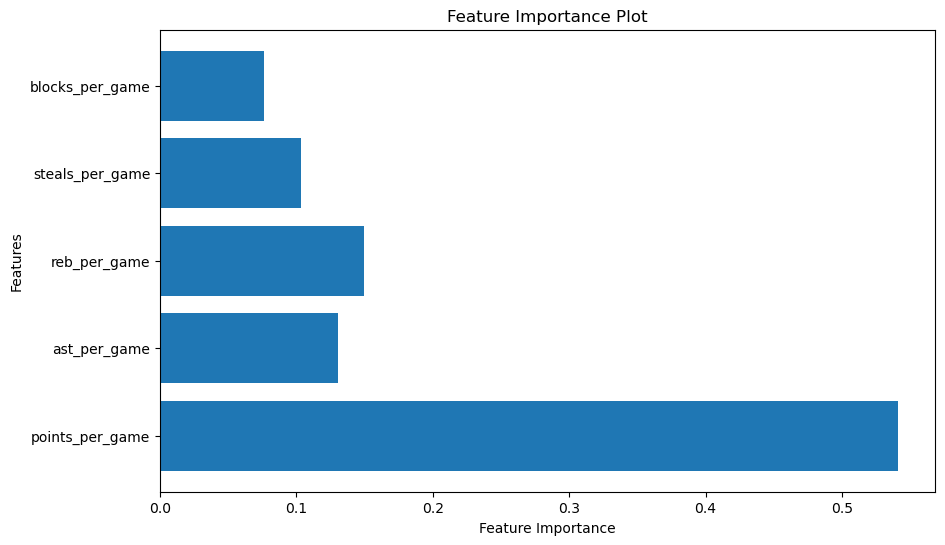

In [1477]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
feature_importances = best_clf.named_steps['classifier'].feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(numeric_features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()


As you can see in the plot above, points per game has the largest effect on the model that is being used to predict a each players' outcome, more than all the other features combined.

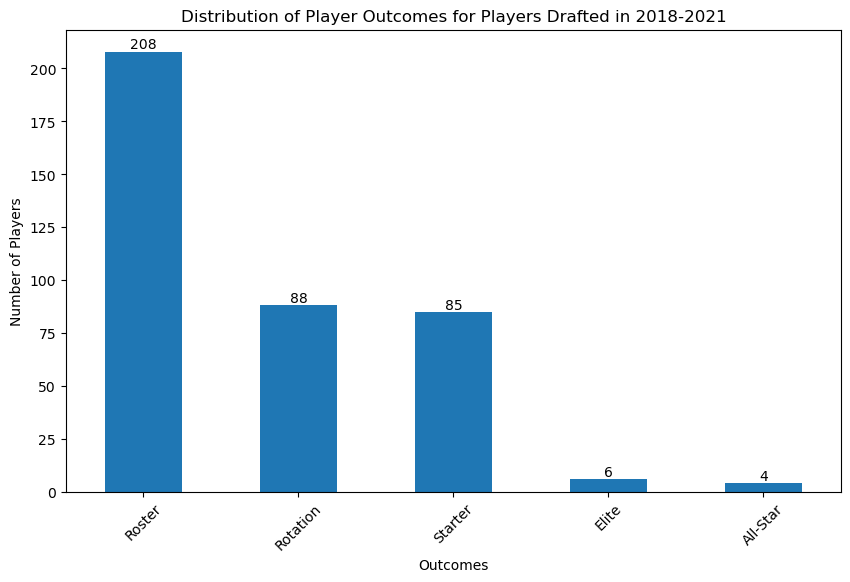

In [1488]:
# Define a mapping dictionary that associates class labels (outcomes) with their corresponding categories
mapping = {
    2: "Roster",
    3: "Rotation",
    4: "Starter",
    5: "All-Star",
    6: "Elite"
}

# Visualization of player ranking distribution
plt.figure(figsize=(10, 6))

# Map outcome keys to their corresponding values using the 'map' function
outcome_labels = val_data['predictions'].map(mapping)

# Get the value counts for each outcome category
outcome_counts = outcome_labels.value_counts()

# Plot the distribution of outcome labels 
ax = outcome_counts.plot(kind='bar')
plt.title("Distribution of Player Outcomes for Players Drafted in 2018-2021")
plt.xlabel("Outcomes")
plt.ylabel("Number of Players")
plt.xticks(rotation=45)

# Annotate each bar with the corresponding count
for idx, count in enumerate(outcome_counts):
    ax.annotate(str(count), xy=(idx, count), ha='center', va='bottom')

plt.show()

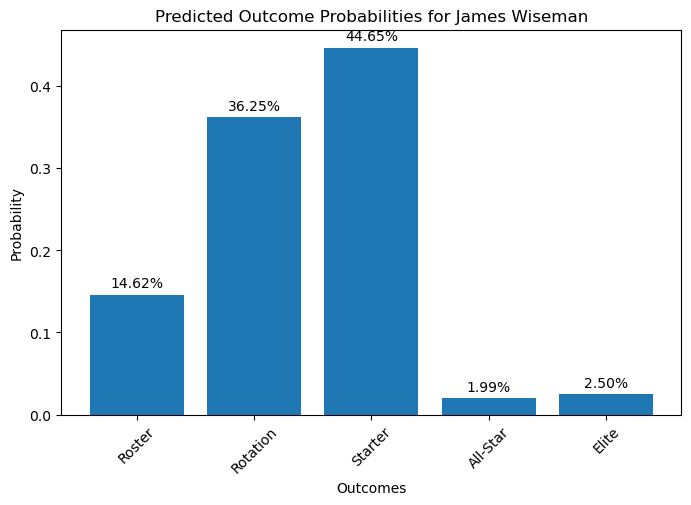

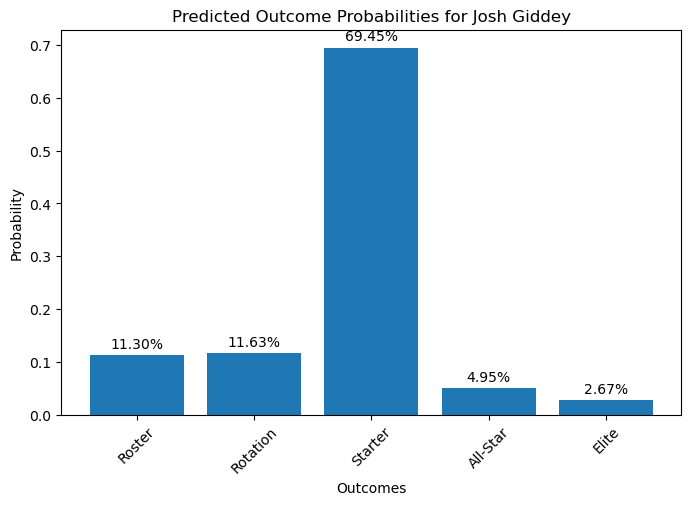

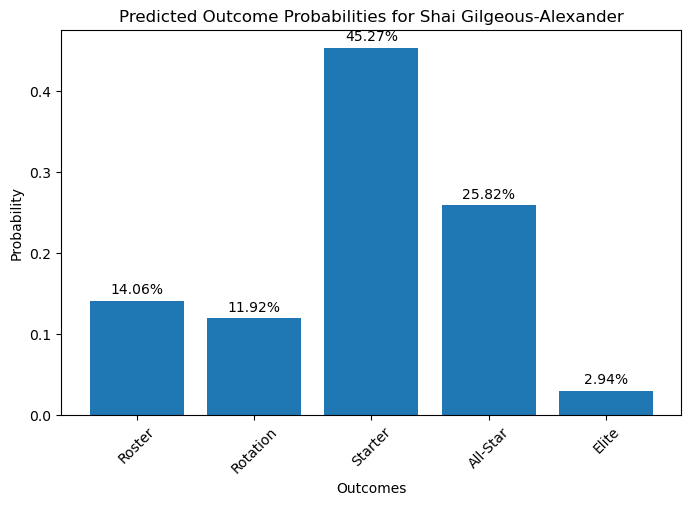

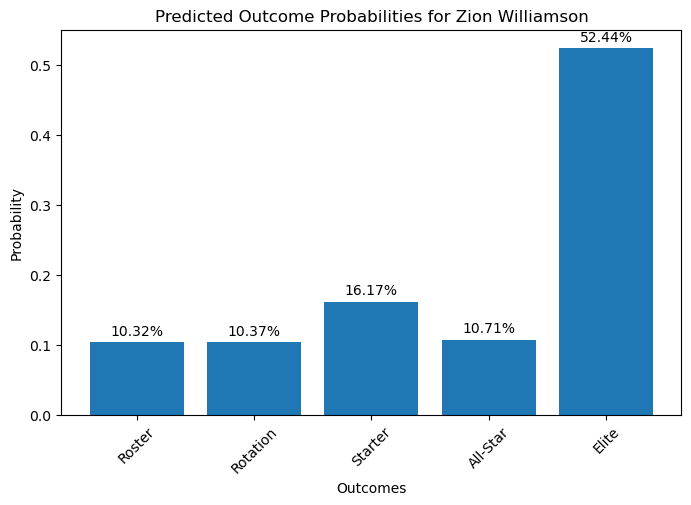

In [1479]:
# Visualization of predicted probabilities for specific players
players_to_print = ['Shai Gilgeous-Alexander', 'Zion Williamson', 'James Wiseman', 'Josh Giddey']

for player, probs in zip(val_data['player'], probabilities):
    if player in players_to_print:
        plt.figure(figsize=(8, 5))
        bars = plt.bar(mapping.values(), probs)
        plt.title(f"Predicted Outcome Probabilities for {player}")
        plt.xlabel("Outcomes")
        plt.ylabel("Probability")
        plt.xticks(rotation=45)

        # Annotate the actual probability values on top of the bars
        for bar, prob in zip(bars, probs):
            plt.annotate(f"{prob:.2%}", 
                         xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')

        plt.show()


In [1469]:
from IPython.display import display, HTML

player_probs = []

# Iterate through player names and their predicted class probabilities
for player, probs in zip(val_data['player'], probabilities):
    
    # Format probabilities as percentages and associate them with class labels
    formatted_probs = [f"{prob:.2%}" for cls, prob in zip(best_clf.classes_, probs)]
    
    # Append player name and formatted probabilities to the list
    player_probs.append([player] + formatted_probs)

# Create a DataFrame with player names and their associated probabilities
probs_df = pd.DataFrame(player_probs, columns=["Player Name"] + list(mapping.values()))

# Convert the DataFrame to an HTML table
html_table = probs_df.to_html(index=False, escape=False, classes=["table", "table-bordered", "table-hover"])

# Display the HTML table 
display(HTML(html_table))

Player Name,Roster,Rotation,Starter,All-Star,Elite
Aaron Henry,80.28%,12.33%,5.48%,0.84%,1.06%
Aaron Holiday,32.22%,46.88%,15.81%,2.34%,2.75%
Aaron Nesmith,81.89%,10.42%,5.74%,0.86%,1.08%
Aaron Wiggins,30.10%,34.48%,31.03%,1.94%,2.44%
Adam Mokoka,80.63%,12.05%,5.40%,0.85%,1.07%
Admiral Schofield,82.10%,10.45%,5.50%,0.86%,1.09%
Ahmad Caver,80.63%,12.05%,5.40%,0.85%,1.07%
Aleem Ford,82.15%,9.81%,6.09%,0.86%,1.09%
Aleksej Pokusevski,14.77%,39.80%,41.63%,1.68%,2.12%
Alen Smailagic,81.78%,10.69%,5.59%,0.86%,1.08%


## Part 2 -- Predicting Team Stats  

In this section, we're going to introduce a simple way to predict team offensive rebound percent in the next game and then discuss ways to improve those predictions.  
 
### Question 1   

Using the `rebounding_data` dataset, we'll predict a team's next game's offensive rebounding percent to be their average offensive rebounding percent in all prior games. On a single game level, offensive rebounding percent is the number of offensive rebounds divided by their number offensive rebound "chances" (essentially the team's missed shots). On a multi-game sample, it should be the total number of offensive rebounds divided by the total number of offensive rebound chances.    

Please calculate what OKC's predicted offensive rebound percent is for game 81 in the data. That is, use games 1-80 to predict game 81.  

In [456]:
# Filter data for OKC and games 1-80
okc_data = rebounding_data[(rebounding_data['team'] == 'OKC') & (rebounding_data['game_number'] <= 80)]

In [457]:
# Calculate total offensive rebounds and total offensive rebound chances
total_offensive_rebounds = okc_data['offensive_rebounds'].sum()
total_offensive_rebound_chances = okc_data['off_rebound_chances'].sum()

In [458]:
# Calculate the average offensive rebounding percentage
average_offensive_rebound_pct = total_offensive_rebounds / total_offensive_rebound_chances

In [ ]:
# Predicted offensive rebounding percentage for game 81
predicted_offensive_rebound_pct = average_offensive_rebound_pct 

print(f"OKC's Predicted Offensive Rebound Percentage for Game 81 is {predicted_offensive_rebound_pct:.1%}")

<strong><span style="color:red">ANSWER 1:</span></strong>  

28.9% 

### Question 2  

There are a few limitations to the method we used above. For example, if a team has a great offensive rebounder who has played in most games this season but will be out due to an injury for the next game, we might reasonably predict a lower team offensive rebound percent for the next game.  

Please discuss how you would think about changing our original model to better account for missing players. You do not have to write any code or implement any changes, and you can assume you have access to any reasonable data that isn't provided in this project. Try to be clear and concise with your answer.  

<strong><span style="color:red">ANSWER 2:</span></strong>  

To better account for missing players and potential changes in team dynamics, we could consider the following strategies:

1. **Injury and Player Availability Data:** Incorporate injury and player availability data into the model. If a key offensive rebounder is injured or unavailable for the next game, this information could be factored into the prediction. This could involve creating a binary variable that indicates whether a player is available for the next game or not. By doing this, we could calculate the average offensive rebounding percentage for the specific players who are expected to play in the upcoming game. This would provide a more accurate estimate of the team's performance given the players who will be on the court.

2. **Advanced Metrics:** Incorporate advanced player metrics such as individual rebounding rates, offensive rebounding opportunity rates, and lineup analysis. These metrics can provide insights into how players contribute to rebounding opportunities and how the whole team perform in terms of rebounding. For example, if a player has consistently demonstrated strong offensive rebounding stats in previous games, their absence might have a more significant impact on the team's overall offensive rebounding percentage.

3. **Team Strategy:** Potential changes in the team's offensive strategy due to missing players should be accounted for. For instance, in the absence of certain players, the team might opt for a more conservative offensive strategy to minimize turnovers and fast-break opportunities for the opponent. This approach could lead to fewer aggressive attempts at offensive rebounds.

4. **Real-Time Data Integration:** If real-time data is available, the model could be continuously updated as the game progresses. This would allow adjustments to predictions based on the actual in-game performance and the dynamic interaction of players on the court. Real-time information about player substitutions and lineup changes can be crucial in adjusting offensive rebounding predictions. Substitutions can lead to variations in player roles and positions, affecting offensive rebounding opportunities. 

### Question 3

In question 2, you saw and discussed how to deal with one weakness of the model. For this question, please write about 1-3 other potential weaknesses of the simple average model you made in question 1 and discuss how you would deal with each of them. You may either explain a weakness and discuss how you'd fix that weakness, then move onto the next issue, or you can start by explaining multiple weaknesses with the original approach and discuss one overall modeling methodology you'd use that gets around most or all of them. Again, you do not need to write any code or implement any changes, and you can assume you have access to any reasonable data that isn't provided in this project. Try to be clear and concise with your answer.

<strong><span style="color:red">ANSWER 3:</span></strong>  

A few other potential weaknesses of the simple average model and how they could be addressed include:

1. **Player Heterogeneity:** The simple average model treats all players equally and calculates the average offensive rebounding percentage across all players. It doesn't account for the fact that some players have a more significant impact on offensive rebounding than others (For example, centers should be able to get more offensive rebounds compared to guards). 
    * **Solution:** To address this, we can implement a weighted average approach based on player characteristics. We can assign weights to players based on their historical offensive rebounding performance, positions, playing time, and other relevant attributes. This approach would give more influence to players who are historically strong offensive rebounders or who are expected to have a greater impact on the upcoming game. 
    
2. **Opponent Variation:** The simple average model does not account for the defensive strategies of the opponent team, which can affect offensive rebounding opportunities. Different opponents have different defensive strengths and weaknesses, such as having less-dominant centers that will influence the team's offensive rebounding success.
    * **Solution:** To overcome this, we can integrate opponent-specific data into the model by including features such as the opponent's defensive rebounding rate, player size, playing style, matchup history, and more. This would enable the model to adjust its predictions based on the opponent's defensive tendencies.
3. **Game Context:** The simple average model treats each game equally and doesn't consider the context of the game. A game with a large lead might result in fewer offensive rebounding chances and vice versa. The model treats performances with the outcome of the game still in question (e.g. score tied with three minutes left) in exactly the same way as they treat performances with the outcome virtually decided (e.g. when one team leads by 40 points with one minute left). 
   
   * **Solution:** To address this, we can incorporate game context variables into the model by considering features like score differential, pace of play, time left in the game, and so on. These variables can help the model account for situations where offensive rebounding might be more or less emphasized by the team due to the game's dynamics.
   